# AI and Machine Learning
*Student - Zagoska Maksim*


Tasks:

1. Applied K nearest neighbors (KNN kernel) weighted by STOLP algorithm for five classes converged with MakeClassification

2. Create compactness for the generated profile dataset

3. For the generated dataset, reduce the optimization by choosing the error window (or the changing window method)

4. Find a small dataset with pictures (2-3 classes) (100 pictures are enough, classified). Find a method\library for building embedding (vectorization) of images. Apply this method on pictures. Apply KNN (no comparison) to the resulting data set from vectorized images.

5. Task 4 with your photos.*Курсив*

**Task 1**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
from mlxtend.plotting import plot_decision_regions

from typing import Mapping
import math

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors


from scipy.spatial import KDTree

In [2]:
seed = np.random.seed(11)

Data generation

In [3]:
X, Y = make_classification(n_samples=1000, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=seed)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=seed)

**KNN**

In [4]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=6)

In [5]:
predictions = model.predict(X_test)

In [6]:
model.kneighbors(X_test, return_distance=False)

array([[ 37, 779, 411, 220, 748, 625],
       [465, 493, 503, 321, 412, 400],
       [543, 612,  87, 192, 356, 473],
       ...,
       [298, 276, 789, 656, 199, 731],
       [216, 772, 447, 440, 198, 414],
       [ 96, 629, 708, 242, 752, 535]])

In [8]:
model.kneighbors(X_test[5].reshape(1, -1), return_distance=False)

array([[759, 407,  44, 798, 195, 286]])

In [10]:
def plot(data, preds, title, marker='o', size=30):
    colors = ['#FF5733', '#BFFF4B', '#5966DA', '#FFC300', '#D859DA']
    c = [colors[i] for i in preds]
    fig = plt.figure()
    ax = fig.add_subplot(111, 
                         projection='3d'
                        )
    ax.set_title(title)
    ax.scatter(data[ : , 0], 
               data[ : , 1], 
               data[ : , 2], 
               c=c, marker=marker,
               s=size)
    plt.show()
    
    
def plot_compare(data, labels, lbl_preds, size=60, title=''):
    
    colors = ['#FF5733', '#BFFF4B', '#5966DA', '#FFC300', 
              '#D859DA', '#DAF7A6', '#4BFCFF', '#581845']
    
    fig = plt.figure(figsize=plt.figaspect(0.3))
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title('Real values')
    c = [colors[i] for i in labels]
    ax1.scatter(data[ : , 0], 
                data[ : , 1], 
                data[ : , 2], 
                c=c, s=size)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title(f'Predictions {title}')
    c = [colors[i] for i in lbl_preds]
    ax2.scatter(data[ : , 0], 
                data[ : , 1], 
                data[ : , 2], 
                c=c, s=size)
    
    plt.show()

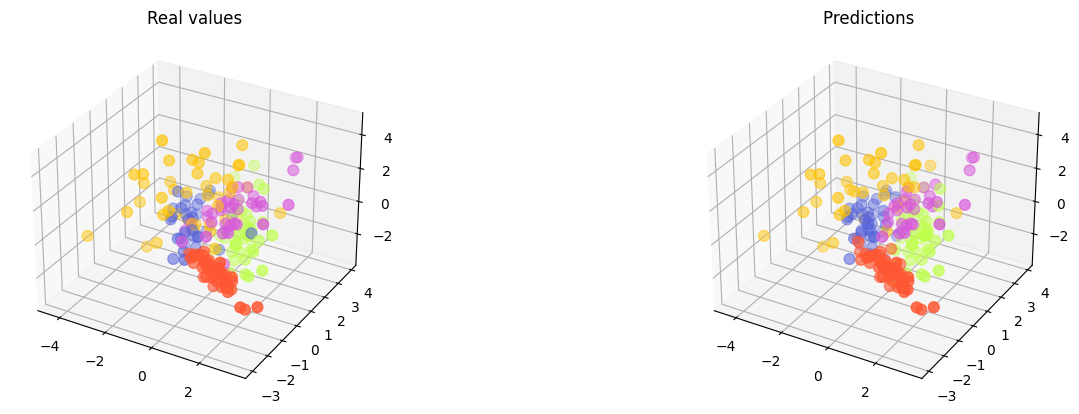

In [11]:
plot_compare(X_test, Y_test, predictions)

In [12]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90        45
           1       0.81      0.85      0.83        41
           2       0.65      0.76      0.70        34
           3       0.86      0.72      0.78        43
           4       0.90      0.73      0.81        37

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.82      0.81      0.81       200



**STOLP**

In [13]:
def compute_margins(xkd, x, y, u, u_ans, n_neigh):
    result = []
    bound = min(n_neigh, y.shape[0]) # задаем количество ближайших соседей для исследования
    
    for cur_u_idx, cur_u_coord in enumerate(u):  # задаем индекс каждой точке в u
        idx = xkd.kneighbors(cur_u_coord.reshape(1, -1), return_distance=False)
        idx = idx.tolist()[0]  # сохраняем индексы ближайших соседей
        maj = {}
        
        for i in idx:
            y_cur = y[i]  # перебираем все класс в ближайших соседях по их индексу
            di = np.linalg.norm(cur_u_coord - x[i])  # расстояние от текущей точки до каждой точки в данных
            dn = np.linalg.norm(cur_u_coord - x[idx[bound - 1]])  # расстояние от текущей точки до предыдущей из n соседей
            w = 0.0
            
            if di != 0.0 and dn > di:
                w = dn / di
                
            maj[y_cur] = maj.get(y_cur, 0) + w  # обновляем в словаре по индексу точки ее вес, 
                                                # если новая точка, то ее вес 0 сначала
            
        cur_u_ans = u_ans[cur_u_idx] # находим в Y_train по текущему индексу класс [u_ans[cur_u_idx]][0]
        correct_score = maj.get(cur_u_ans, 0)  # достаем из словаря вес точки
        del maj[cur_u_ans]
        
        max_wrong = 0
        if len(maj) > 0:
            max_wrong = sorted(maj.items(), key=lambda x: x[1])[-1][1] # находим максимально отдаленный элемент (точку)
            
        result.append(correct_score - max_wrong)  # для рассчета конечной удаленности вычитаем самый большой отступ
        
    return np.array(result)

In [14]:
model = KNeighborsClassifier(n_neighbors=7).fit(X_test, Y_test)

In [15]:
margins = compute_margins(model, X_test, Y_test, X_test, Y_test, 7)

Since we are counting the offset for all points, therefore x and y are the same

In [16]:
len(margins)

200

In [17]:
def stolp(src_x, src_y, err_num, depth_limit, n):

    support_x = []
    support_y = []
    src_xkd = KNeighborsClassifier(n_neighbors=n).fit(src_x, src_y)
    print(src_xkd)
    margins = np.array([compute_margins(src_xkd, src_x, src_y, src_x, src_y, n)]).transpose()
    
    x = src_x[margins[:, 0] > depth_limit]
    y = src_y[margins[:, 0] > depth_limit]
    margins = margins[margins[:, 0] > depth_limit]
    sorted_margs = np.argsort(margins[:, 0])

    for ans in np.unique(y):
        for m in sorted_margs:

            if y[m] == ans:

                support_x.append(x[m])
                support_y.append(y[m])
                x = np.delete(x, (m), axis=0)
                y = np.delete(y, (m), axis=0)
                break
                
    errors = x.shape[0]
#     print(support_x, support_y)
    while errors > err_num:
        xkd = KNeighborsClassifier(n_neighbors=n).fit(np.array(support_x), np.array(support_y))
        margins = compute_margins(xkd, np.array(support_x), np.array(support_y), x, y, n)
        KNN_preds = model.predict(support_x)

        errors = len(KNN_preds[KNN_preds == src_y[:len(KNN_preds)]])
        sorted_margs = np.argsort(margins)  # выводим индексы отсортированных отступов
        to_delete = []
        min = sorted_margs[0]
        support_x.append(x[min])
        support_y.append(y[min])
        to_delete.append(min)
        
        x = np.delete(x, to_delete, axis=0)
        y = np.delete(y, to_delete, axis=0)
        
    return np.array(support_x), np.array(support_y)

In [18]:
stolp_prx, stolp_pry = stolp(X_test, Y_test, err_num=60, depth_limit=0.0001, n=5)

KNeighborsClassifier()


In [19]:
stolp_prx

array([[-0.60578586,  0.19567283, -1.7275751 ],
       [ 1.22961125,  1.15526889, -0.27130537],
       [-1.57243702,  2.06213663, -0.22843579],
       [ 0.0618425 ,  1.69253063,  1.43574773],
       [-0.2210118 ,  2.11178917,  0.92071537],
       [-0.74936345,  0.49406681, -1.62653511]])

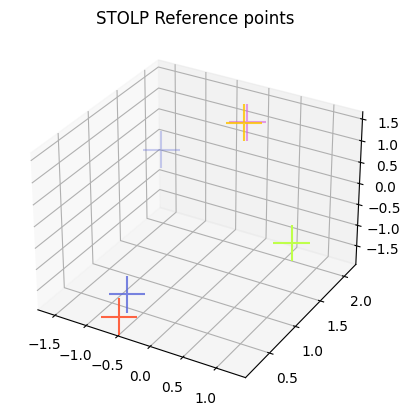

In [22]:
plot(stolp_prx, stolp_pry, 'STOLP Reference points', '+', 700)

**Compact profile**

In [23]:
def compactness_profile(index:int, X, y, metric='euclidean'):
    """
    index: индекс
    X: матрица объект-признак, для которой хотим посчитать профиль компактности
    y: вектор таргетов для этих объектов
    metric: ['euclidean', 'cosine', ...]
    """
    assert 0 <= index <= X.shape[0]
    neigh = NearestNeighbors(n_neighbors=X.shape[0], metric=metric)
    neigh.fit(X, y)
    distances, indexes = neigh.kneighbors(X)
    return (y != y[indexes[:, index]]).mean() # возвращаем значения для профиля компактности

In [24]:
length = np.array(list(range(1, X_train.shape[0])))
comp_vals = np.array([compactness_profile(i, X_train, Y_train) for i in length])

fig = px.line(x=length, y=comp_vals)
fig.show()

**Parzen Window Method**

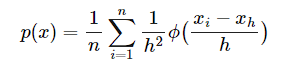

 
 - where n is number of elements in the vector, x is a vector, p(x) is a probability density of x, h is dimension of the Parzen Window, and 
 is a window function.

In [25]:
gauss_kernel = lambda x: ((2 * math.pi) ** (-1/2)) * np.exp(-1/2 * (x ** 2))

In [26]:
distance = lambda point1, point2: math.sqrt((point1[0] - point2[0]) ** 2 \
                                            + (point1[1] - point2[1]) ** 2 \
                                            + (point1[2] - point2[2]) ** 2
                                           )

In [27]:
def ParzRos_score(x: float, h: float, data: np.array, kernel: Mapping, distance: Mapping) -> float:
    """
    Function: 
        Метод возвращает значение, найденное методом Парзена-Розенблатта для группы точек.

    Args: 
        x: float - параметр функции ядра.
        h: float - параметр метода Парзена-Розенблатта: ширина окна.
        data: list или array - набор точек.
        kernel: Mapping - тип ядра.
        distance: Mapping - функция расчета расстояния между двумя точками 
                        на плоскости или в пространстве (для нелинейной задачи).

    Return:
        Значение найденное методом Парзена-Розенблатта для группы точек (float).
    """
    return sum([kernel(distance(x, point) / h) for point in data]) / (len(data) * h)

**Функция ядра (окна)**

image.png — произвольная четная функция, называемая функцией ядра или окна. Термин окно происходит из классического вида функции:

 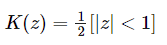


Ширина окна

Ширина окна сильно влияет на качество восстановления плотности и, как следствие, классификации. При слишком малом окне мы получаем тот же эффект, что и при использовании гистограммы значений. При слишком большом окне плотность вырождается в константу.

Для нахождения оптимальной ширины окна удобно использовать принцип максимума правдоподобия с исключением объектов по одному (leave-one-out, LOO).

Возможные проблемы

Проблема локальных сгущений

Возникает в тех случаях, когда распределение объектов в пространстве сильно неравномерно, и одно и то же значение ширины окна h приводит к чрезмерному сглаживанию плотности в одних местах, и недостаточному сглаживанию в других. Проблему решают окна переменной ширины.

Проблема «проклятия размерности»

Если число признаков велико и учитываются все они, то все объекты оказываются примерно на одинаковом расстоянии друг от друга. Выход заключается в понижении размерности с помощью преобразования пространства признаков, либо путём отбора информативных признаков.

In [28]:
def ParzWindow(distance: Mapping, h: float) -> float:
    """
    Function: 
        Метод возвращает значение, найденное методом окна Парзена для группы точек.

    Args: 
        distance: Mapping - расстояния между двумя точками 
                на плоскости или в пространстве.
        h: float - параметр метода Парзена: ширина окна.

    Return:
        Значения найденные методом окна Парзена для группы точек (float).
    """
    return (1 - (np.array(distance) / h) ** 2) * (np.abs(np.array(distance) / h) <= 1)

In [29]:
model_parz = KNeighborsClassifier(n_neighbors=3,
                                 weights=lambda x: ParzWindow(x, h=0.7)
                              #ParzRos_score(x, 0.05, X_train, gauss_kernel, distance)
                             )
model_parz.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3,
                     weights=<function <lambda> at 0x7f6340ddc040>)

In [30]:
predictions_parz = model_parz.predict(X_test)

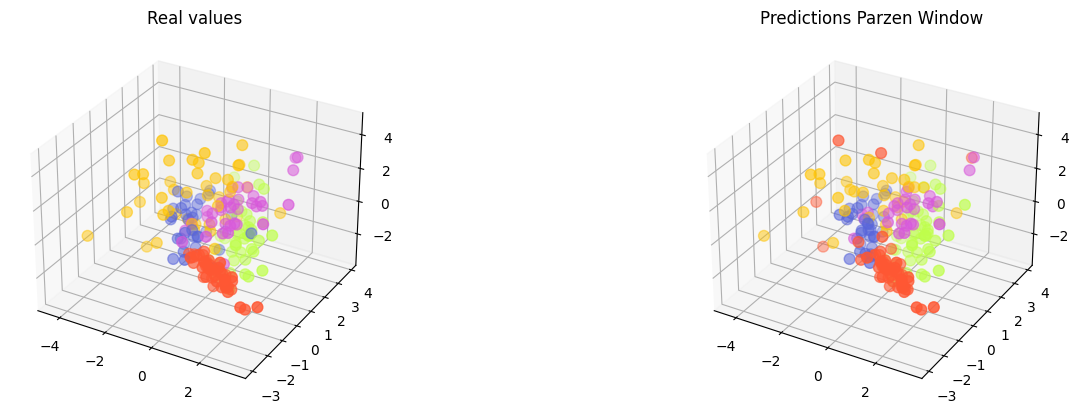

In [31]:
plot_compare(X_test, Y_test, predictions_parz, title='Parzen Window')

**KNN for vectorized pictures**

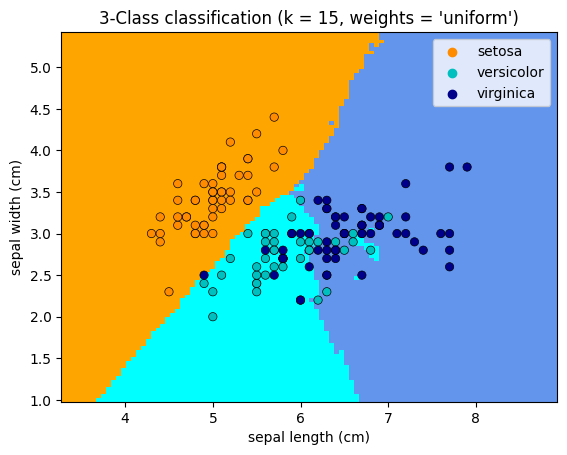

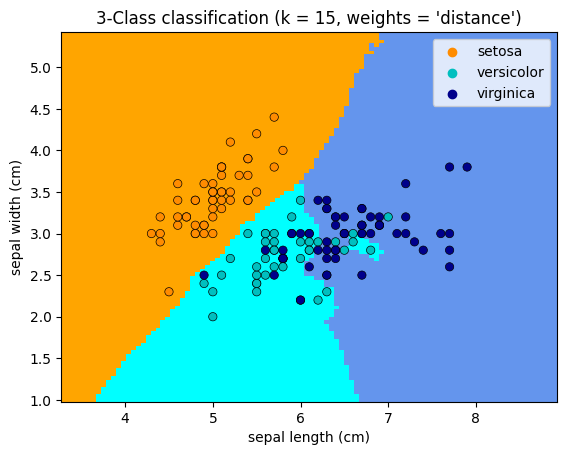

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )

plt.show()

In [33]:
!conda update scikit-learn

/bin/bash: conda: command not found


In [34]:
!python3 -m pip install --upgrade --user scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
